He usado el dataset "Forest Covertypes" de <br/>
http://archive.ics.uci.edu/ml/datasets/Covertype

El original tenía unas 500 000 instancias, y eso era demasiado, así que he sacado un subconjunto <br/>
Es un problema de clasificación con 7 clases con datos categóricos y numéricos <br/>

El problema era que las instancias de cada una de las clases estaban muy mal distribuidas: <br/>
- 1 &rarr; 36 % <br/>
- 2 &rarr; 48 % <br/>
- 3 &rarr; 6 % <br/>
- 4 &rarr; 0.4 % <br/>
- 5 &rarr; 1 % <br/>
- 6 &rarr; 3 % <br/>
- 7 &rarr; 3.5 % <br/>

Entonces he cogido 700 instancias aleatorias de cada una de las clases y las he juntado en otro <br/>
dataset, que es el que estoy cargando <br/>

Por eso tiene 4900 instancias

In [1]:
import ipywidgets as widgets

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [3]:
# Imports
%matplotlib inline
import matplotlib.pyplot as plt
import json
import numpy as np
import math

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

from IPython.display import Markdown as md

In [4]:
estimator = widgets.Dropdown(
    options = ["DecisionTreeClassifier","RandomForestClassifier", ],
    description = "Clasificador: ")
N_estims = widgets.IntSlider(
    min = 5,
    max = 150,
    step = 5)

In [5]:
chosen_clf = estimator.value

estims = {}
if chosen_clf == "RandomForestClassifier":
    estims = {"n_estimators":N_estims.value}

In [6]:
# Retorna una tupla (data, target) con todo el preprocesado hecho
def get_data():
    with open("data_4900.json", "r") as jd:
        d = json.load(jd)
    
    data = d['data']
    target = d['target']
    
    data = np.array(data)
    target = np.array(target)
    
    # Quitar las columnas que tienen todo 0
    data = data[:, np.count_nonzero(data, axis = 0) > 0]
    # Realmente lo que tendría que hacer es quitar las
    # columnas en las que son todos iguales. Sino la std
    # también podría ser 0. De momento da igual
    
    mean = data.mean(axis = 0)
    std = data.std(axis = 0)
    
    data = (data - mean)/std
    
    #Hay que cambiar el orden, pues está ordenado por clases
    ordering = np.arange(len(target))
    np.random.shuffle(ordering)
    
    data = data[ordering]
    target = target[ordering]
    
    
    return data, target

In [7]:
def show_accuracy(tune_param, decreases):
    data, target = get_data()

    N = data.shape[0]
    prop_train = 2 / 3
    N_train = math.ceil(N * prop_train)
    N_test = N - N_train

    data_train = data[:N_train]
    data_test = data[N_train:]

    target_train = target[:N_train]
    target_test = target[N_train:]

    clf_pipe = Pipeline([
          ("pca", PCA(n_components = 0.9, svd_solver = "full")),
          #("clf", DecisionTreeClassifier())
          ("clf", eval(chosen_clf)(**estims))
      ])

    #clf = DecisionTreeClassifier()
    clf = eval(chosen_clf)(**estims)



    train_scores = []
    test_scores = []

    pca_train_scores = []
    pca_test_scores = []

    for dec in decreases:
      #clf.set_params(min_impurity_decrease = dec)
      clf.set_params(**{tune_param: dec})
      clf.fit(data_train, target_train)
      test_score = clf.score(data_test, target_test)
      train_score = clf.score(data_train, target_train)
      test_scores.append(test_score)
      train_scores.append(train_score)
      
      #clf_pipe.set_params(dtc__min_impurity_decrease = dec)
      clf_pipe.set_params(**{"clf__"+tune_param: dec})
      clf_pipe.fit(data_train, target_train)
      pca_test_score = clf_pipe.score(data_test, target_test)
      pca_train_score = clf_pipe.score(data_train, target_train)
      pca_test_scores.append(pca_test_score)
      pca_train_scores.append(pca_train_score)

    plt.figure(figsize=(15,5))

    accuracy = plt.subplot(121)
    accuracy.set_title("Normal DT")
    accuracy.plot(decreases, test_scores, label = "Test score")
    accuracy.plot(decreases, train_scores, label = "Train score")
    accuracy.locator_params(nbins = 15, axis = "x")
    accuracy.set_xlabel(tune_param)
    accuracy.set_ylabel("accuracy")
    accuracy.grid(True)
    accuracy.legend(loc='best')

    pca_accuracy = plt.subplot(122, sharey = accuracy)
    pca_accuracy.set_title("Using PCA")
    pca_accuracy.plot(decreases, pca_test_scores, label = "Test score")
    pca_accuracy.plot(decreases, pca_train_scores, label = "Train score")
    pca_accuracy.locator_params(nbins = 15, axis = "x")
    pca_accuracy.set_xlabel(tune_param)
    pca_accuracy.set_ylabel("accuracy")
    pca_accuracy.grid(True)
    pca_accuracy.legend(loc='best')


    plt.show()

# Valores por defecto

In [8]:
# Sacar data_test, data_train, etc
data, target = get_data()

N = data.shape[0]
prop_train = 2 / 3
N_train = math.ceil(N * prop_train)
N_test = N - N_train

data_train = data[:N_train]
data_test = data[N_train:]

target_train = target[:N_train]
target_test = target[N_train:]

In [9]:
# Entrenar y evaluar el Estmimador elegido
#clf = DecisionTreeClassifier()
clf = eval(chosen_clf)(**estims)
clf.fit(data_train, target_train)
train_score = clf.score(data_train, target_train)
test_score = clf.score(data_test, target_test)

In [10]:
train_score, test_score

(1.0, 0.7023882424984691)

# Tuneando parámetros

In [11]:
params = {
    "max_depth": np.linspace(1,150, dtype = np.int64),
    "min_samples_split": np.linspace(2,150, dtype = np.int64),
    "min_samples_leaf": np.linspace(1,150, dtype = np.int64),
    "min_weight_fraction_leaf": np.linspace(0,0.5, dtype = np.float64),
    "max_leaf_nodes": np.linspace(2,150, dtype = np.int64),
    "min_impurity_decrease": np.linspace(0,150, dtype = np.float64),
}

In [12]:
def show_graphs(b):
    display(md("### Results of " + estimator.value))
    if estimator.value == "RandomForestClassifier":
        display(md("Number estimators: " + str(N_estims.value)))
    for i in params:
        show_accuracy(i, params[i])

In [13]:
button = widgets.Button(description = "Run")
button.on_click(show_graphs)

Dropdown(description='Clasificador: ', options=('DecisionTreeClassifier', 'RandomForestClassifier'), value='De…

IntSlider(value=5, max=150, min=5, step=5)

Button(description='Run', style=ButtonStyle())

### Results of DecisionTreeClassifier

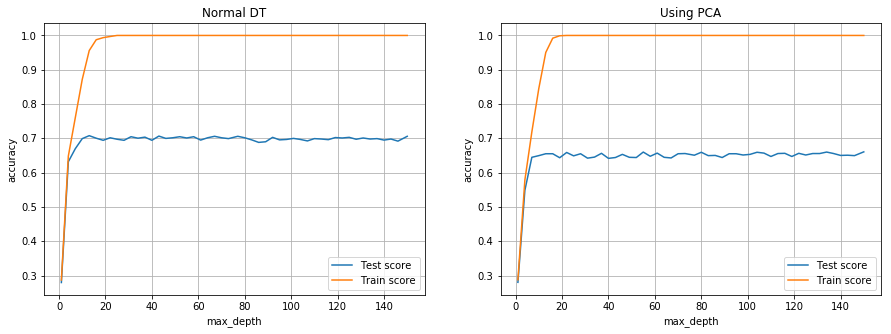

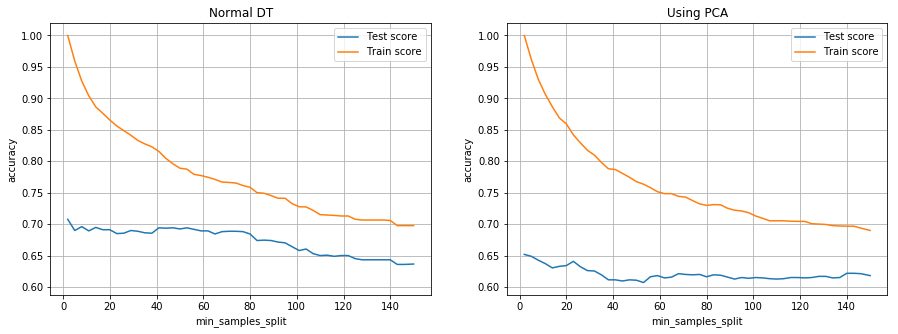

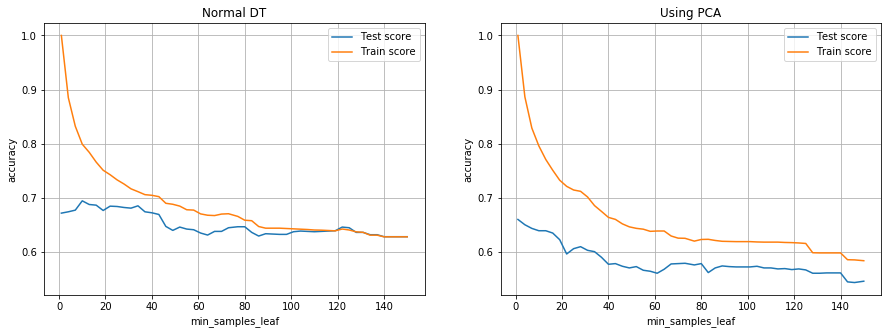

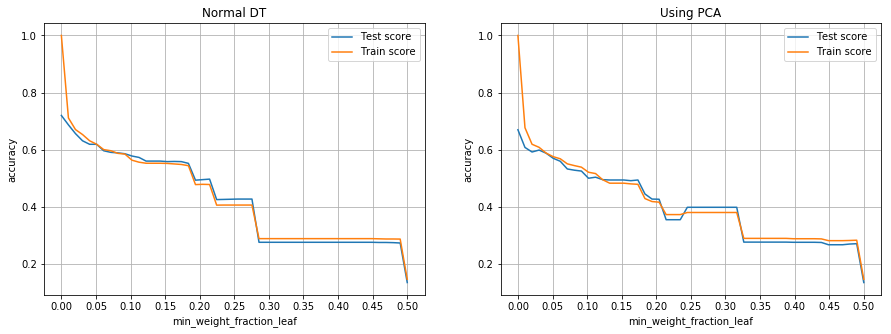

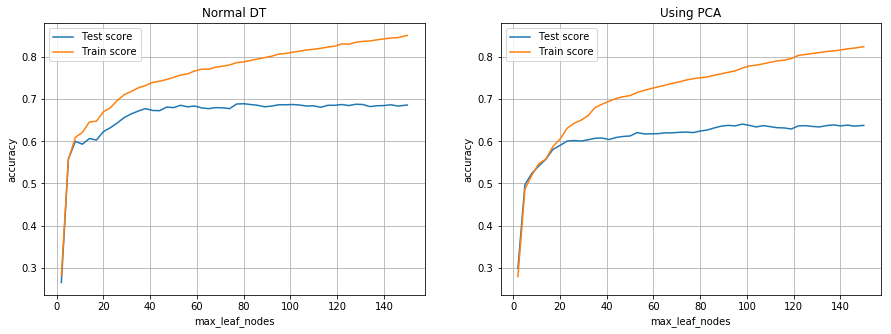

In [14]:
display(estimator)
display(N_estims)
display(button)